### Environment Setup: ModelNet & PyTorch3D

This section sets up the environment for 3D point cloud robustness experiments using PyTorch3D and ModelNet.

**Requirements:**
- PyTorch (with CUDA if available)
- PyTorch3D
- tqdm, matplotlib, numpy, pandas, scikit-learn

**Note:** PyTorch3D requires a compatible PyTorch version. See [https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md] for details.

In [3]:
# Install PyTorch3D (uncomment if not already installed)
# For CUDA 11.7 (adjust for your CUDA version):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# If you are on CPU-only, use:
# pip install torch torchvision torchaudio
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch3D
try:
    from pytorch3d.loss import chamfer_distance
    from pytorch3d.ops import sample_points_from_meshes
    print("PyTorch3D is installed and ready.")
except ImportError:
    print("PyTorch3D is not installed. Please follow the instructions above.")

PyTorch3D is installed and ready.


### Step 1: Download and Prepare ModelNet40 Data

We will download the ModelNet40 dataset, extract it, and preprocess it into point clouds.

- The dataset will be stored in a local directory (e.g., `./modelnet40`).
- Each mesh will be sampled into a fixed number of points (e.g., 1024) for use in point cloud classification.
- This step only needs to be run once.

In [5]:
import os
import urllib.request
import zipfile

DATA_DIR = './modelnet40'
MODELNET_URL = 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
ZIP_PATH = os.path.join(DATA_DIR, 'ModelNet40.zip')

# Download ModelNet40 if not present
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, 'ModelNet40')):
    print('Downloading ModelNet40...')
    urllib.request.urlretrieve(MODELNET_URL, ZIP_PATH)
    print('Extracting ModelNet40...')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print('Done.')
else:
    print('ModelNet40 already downloaded and extracted.')

ModelNet40 already downloaded and extracted.


### Step 2: Create a PyTorch Dataset and DataLoader for ModelNet40 Point Clouds

This step defines a PyTorch Dataset that loads ModelNet40 meshes, samples point clouds using PyTorch3D, and provides them for training and evaluation.

- Each sample is a tuple: (point_cloud [N, 3], label)
- The dataset supports on-the-fly mesh loading and point sampling.
- You can cache sampled point clouds for faster subsequent runs.

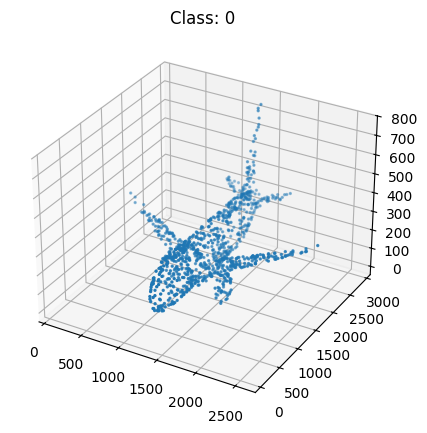

In [6]:
import glob
from torch.utils.data import Dataset, DataLoader
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
import trimesh
import warnings

class ModelNet40PointCloudDataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024, cache=True, random_seed=42):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.cache = cache
        self.random = np.random.RandomState(random_seed)
        self.mesh_paths = []
        self.labels = []
        self.class_map = {}
        self._build_file_list()
        self._cache = {} if cache else None

    def _build_file_list(self):
        classes = sorted([d for d in os.listdir(os.path.join(self.root_dir, 'ModelNet40')) if os.path.isdir(os.path.join(self.root_dir, 'ModelNet40', d))])
        self.class_map = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            split_dir = os.path.join(self.root_dir, 'ModelNet40', cls, self.split)
            if not os.path.exists(split_dir):
                continue
            for off_file in glob.glob(os.path.join(split_dir, '*.off')):
                self.mesh_paths.append(off_file)
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.mesh_paths)

    def __getitem__(self, idx):
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        try:
            # Load mesh using trimesh
            mesh = trimesh.load(mesh_path)
            verts = torch.tensor(mesh.vertices, dtype=torch.float32)
            faces = torch.tensor(mesh.faces, dtype=torch.int64)
            
            if verts.shape[0] < self.num_points or faces.shape[0] == 0:
                raise ValueError("Mesh has too few vertices or faces.")
            
            mesh = Meshes(verts=[verts], faces=[faces])
            points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
            
            if torch.isnan(points).any() or torch.isinf(points).any():
                raise ValueError("Sampled points contain NaN or Inf.")
            label = self.labels[idx]
            sample = (points, label)
            if self.cache:
                self._cache[idx] = sample
            return sample
        except Exception as e:
            warnings.warn(f"Error loading item {idx}, path: {mesh_path}: {e}")
            # Return a dummy sample (random points, random label) to keep DataLoader running
            points = torch.randn(self.num_points, 3)
            label = 0
            return (points, label)

train_dataset = ModelNet40PointCloudDataset('./modelnet40', split='train', num_points=1024)
test_dataset = ModelNet40PointCloudDataset('./modelnet40', split='test', num_points=1024)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Visualize a sample point cloud
points, label = train_dataset[0]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), points[:, 2].cpu(), s=2)
ax.set_title(f'Class: {label}')
plt.show()

### Step 3: Define a Custom Point Cloud Classification Model

We define a simple custom model for point cloud classification. This model uses shared MLPs (1D convolutions), global max pooling, and fully connected layers.

- Input: point cloud of shape (B, N, 3)
- Output: logits for each class (B, num_classes)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplePointNet(nn.Module):
    def __init__(self, num_classes=40, input_dim=3):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(input_dim, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        # x: (B, N, 3)
        x = x.transpose(2, 1)  # (B, 3, N)
        x = self.mlp1(x)      # (B, 256, N)
        x = torch.max(x, 2)[0]  # (B, 256)
        x = self.fc(x)
        return x

### Step 4: Adversarial Attacks and Corruptions for Point Clouds

This section implements:
- FGSM and PGD adversarial attacks for point clouds
- Simple weather corruptions (Gaussian noise, snow, fog)

All functions operate on torch tensors of shape (B, N, 3).

In [8]:
import torch
import torch.nn.functional as F
import numpy as np

# --- Adversarial Attacks ---
def fgsm_attack(model, points, labels, epsilon):
    """
    FGSM attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3) input point cloud
        labels: (B,) ground truth labels
        epsilon: attack strength
    Returns:
        perturbed_points: (B, N, 3)
    """
    points_adv = points.clone().detach().requires_grad_(True)
    model.eval()  # Ensure model is in eval mode for attack
    outputs = model(points_adv)
    loss = F.cross_entropy(outputs, labels)
    # Zero out any existing gradients
    if points_adv.grad is not None:
        points_adv.grad.zero_()
    loss.backward()
    grad = points_adv.grad
    perturbed_points = points + epsilon * grad.sign()
    return perturbed_points.detach()

def pgd_attack(model, points, labels, epsilon, alpha, num_iter):
    """
    PGD attack for point clouds.
    Args:
        model: classification model
        points: (B, N, 3)
        labels: (B,)
        epsilon: max perturbation
        alpha: step size
        num_iter: number of steps
    Returns:
        perturbed_points: (B, N, 3)
    """
    ori_points = points.clone().detach()
    perturbed = ori_points + torch.empty_like(ori_points).uniform_(-epsilon, epsilon)
    perturbed.requires_grad = True
    for _ in range(num_iter):
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        grad = perturbed.grad.data
        perturbed = perturbed + alpha * grad.sign()
        perturbed = torch.max(torch.min(perturbed, ori_points + epsilon), ori_points - epsilon)
        perturbed = perturbed.detach().requires_grad_(True)
    return perturbed.detach()


In [9]:
import torch.optim as optim
import traceback

# First, let's fix the dataset's __getitem__ method to handle errors better
def safe_getitem(self, idx):
    try:
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        mesh = trimesh.load(mesh_path)
        verts, faces = torch.from_numpy(mesh.vertices).float(), torch.from_numpy(mesh.faces).long()
        mesh = Meshes(verts=[verts], faces=[faces])
        points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
        label = self.labels[idx]
        sample = (points, label)
        if self.cache:
            self._cache[idx] = sample
        return sample
    except Exception as e:
        print(f"Error loading item {idx}, path: {self.mesh_paths[idx]}: {str(e)}")
        # Return a dummy sample of correct shape as fallback
        dummy_points = torch.zeros((self.num_points, 3))
        return dummy_points, 0

# Apply the patched method to the dataset class
ModelNet40PointCloudDataset.__getitem__ = safe_getitem

# Create new data loaders with fewer workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Use a small subset for quick debugging/training
from torch.utils.data import Subset

small_train_indices = list(range(0, 1024))  # Use only 256 samples for quick test
small_test_indices = list(range(0, 256))   # Use only 64 samples for quick test

small_train_dataset = Subset(train_dataset, small_train_indices)
small_test_dataset = Subset(test_dataset, small_test_indices)

small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=0)
small_test_loader = DataLoader(small_test_dataset, batch_size=16, shuffle=False, num_workers=0)


### Step 5: Advanced Real-World Corruptions for 3D Point Clouds

Here we implement more realistic corruptions that simulate real-world challenges in 3D sensing:
- **Occlusion**: Simulates objects blocking the view by removing spherical regions
- **LiDAR Noise**: Distance-dependent noise and reflectivity issues
- **Registration Errors**: Misalignment between multiple scans
- **Rain Simulation**: Models streaks of rain in the scene

In [10]:
def add_occlusion(points, num_spheres=3, occlusion_radius=0.3):
    """
    Simulates occlusion by completely removing points in spherical regions.
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        num_spheres: Number of occlusion spheres to create
        occlusion_radius: Radius of occlusion sphere
        debug: Print number of points removed
    Returns:
        Occluded point cloud with same shape as input, but with occluded points zeroed out
    """
    B, N, _ = points.shape
    device = points.device
    occluded_points = points.clone()
    for b in range(B):
        keep_mask = torch.ones(N, dtype=torch.bool, device=device)
        for _ in range(num_spheres):
            center_idx = torch.randint(0, N, (1,), device=device)
            center = points[b, center_idx, :].squeeze(0)
            dist = torch.norm(points[b] - center, dim=1)
            keep_mask &= (dist > occlusion_radius)
        occluded_points[b][~keep_mask] = 0
    return occluded_points

def add_lidar_noise(points, distance_noise=0.01, reflectivity_drop=0.1):
    """Simulates LiDAR sensor noise - noise increases with distance from origin
    and some points are completely missing due to reflectivity issues.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        distance_noise: Base noise level
        reflectivity_drop: Probability of point dropout
        
    Returns:
        Noisy point cloud with same shape as input
    """
    B, N, _ = points.shape
    device = points.device
    
    # Calculate distance from origin for each point
    distances = torch.norm(points, dim=2)  # Shape: [B, N]
    
    # Noise scales with distance (farther = more noise)
    scaled_noise = distance_noise * distances.unsqueeze(-1)  # Shape: [B, N, 1]
    noise = torch.randn_like(points) * scaled_noise  # Shape: [B, N, 3]
    
    # Randomly drop points based on reflectivity simulation
    keep_mask = (torch.rand(B, N, 1, device=device) > reflectivity_drop).float()
    
    # Apply noise and dropout
    noisy_points = (points + noise) * keep_mask
    
    return noisy_points

def add_registration_error(points, rotation_error=0.05, translation_error=0.05):
    """Simulates registration errors between multiple scans.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        rotation_error: Maximum rotation error in radians
        translation_error: Maximum translation error
        
    Returns:
        Point cloud with registration errors
    """
    B, N, _ = points.shape
    device = points.device
    
    # Deep copy the points
    misaligned_points = points.clone()
    
    # Simulate different registration errors for each batch
    for b in range(B):
        # Randomly split points into two "scans"
        split_idx = torch.randint(N//4, 3*N//4, (1,), device=device)
        mask_first = torch.zeros(N, dtype=torch.bool, device=device)
        mask_first[:split_idx] = True
        
        # Generate random rotation error
        angle = (torch.rand(1, device=device) * 2 - 1) * rotation_error
        cos_val, sin_val = torch.cos(angle), torch.sin(angle)
        
        # Simple rotation matrix (around z-axis for simplicity)
        R = torch.eye(3, device=device)
        R[0, 0], R[0, 1] = cos_val, -sin_val
        R[1, 0], R[1, 1] = sin_val, cos_val
        
        # Generate random translation error
        T = (torch.rand(3, device=device) * 2 - 1) * translation_error
        
        # Apply transformation to second scan
        misaligned_points[b, ~mask_first] = torch.matmul(
            misaligned_points[b, ~mask_first], R.T) + T
            
    return misaligned_points

def add_rain(points, rain_density=0.1, rain_length=0.1, direction=None):
    """Adds vertical rain streaks to the point cloud.
    
    Args:
        points: Point cloud tensor of shape (B, N, 3)
        rain_density: Density of rain (0-1)
        rain_length: Length of rain streaks
        direction: Optional rain direction vector, otherwise vertical
        
    Returns:
        Point cloud with added rain
    """
    B, N, _ = points.shape
    device = points.device
    
    # Set rain direction (default is vertical down)
    if direction is None:
        direction = torch.tensor([0.0, 0.0, -1.0], device=device)
    else:
        direction = F.normalize(direction, dim=0)
    
    # Number of raindrops to add
    num_drops = int(N * rain_density)
    
    # Result tensor with original points
    result = points.clone()
    
    for b in range(B):
        if num_drops > 0:
            # Randomly select positions for raindrops above the scene
            # Find the highest z-value in the scene and place rain above it
            max_z = points[b, :, 2].max().item()
            
            # Create rain start positions
            x_range = points[b, :, 0].max() - points[b, :, 0].min()
            y_range = points[b, :, 1].max() - points[b, :, 1].min()
            x_min, y_min = points[b, :, 0].min(), points[b, :, 1].min()
            
            # Create random starting positions for raindrops
            rain_x = torch.rand(num_drops, device=device) * x_range + x_min
            rain_y = torch.rand(num_drops, device=device) * y_range + y_min
            rain_z = torch.ones(num_drops, device=device) * (max_z + 0.1)
            
            rain_starts = torch.stack([rain_x, rain_y, rain_z], dim=1)
            
            # Create rain streaks (start and end points)
            rain_ends = rain_starts + direction * rain_length
            
            # Sample points along the rain streaks
            t = torch.rand(num_drops, 5, device=device).unsqueeze(-1)  # 5 points per streak
            rain_points = rain_starts.unsqueeze(1) * (1 - t) + rain_ends.unsqueeze(1) * t
            rain_points = rain_points.view(-1, 3)
            
            # Add the rain points by replacing some of the original points
            replace_indices = torch.randperm(N, device=device)[:rain_points.shape[0]]
            result[b, replace_indices] = rain_points[:replace_indices.shape[0]]
    
    return result

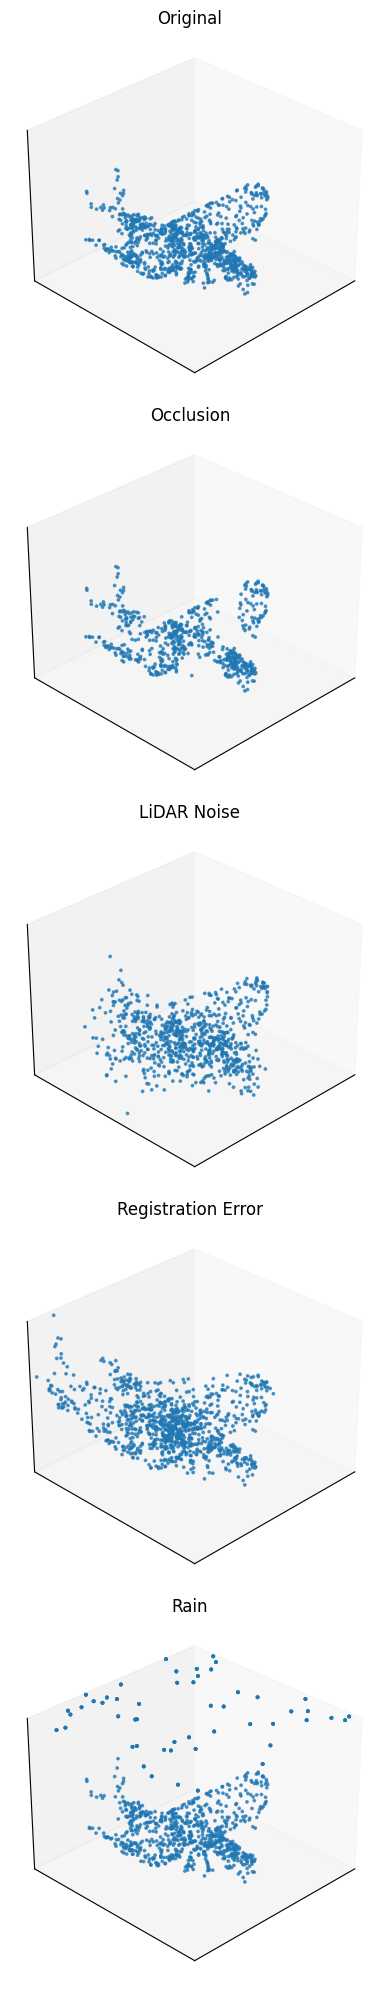

In [11]:
def visualize_all_corruptions(points):
    """Visualize original and all corruptions stacked vertically."""
    corruptions = [
        ("Original", points),
        ("Occlusion", add_occlusion(points, num_spheres=10, occlusion_radius=200)),
        ("LiDAR Noise", add_lidar_noise(points, distance_noise=0.03, reflectivity_drop=0.2)),
        ("Registration Error", add_registration_error(points, rotation_error=0.5, translation_error=0.4)),
        ("Rain", add_rain(points, rain_density=0.05, rain_length=0.2)),
    ]
    n = len(corruptions)
    fig = plt.figure(figsize=(6, 4*n))
    for i, (title, pts) in enumerate(corruptions):
        ax = fig.add_subplot(n, 1, i+1, projection='3d')
        mask = ~torch.all(pts[0] == 0, dim=1)
        if mask.sum() > 0:
            ax.scatter(pts[0, mask, 0].cpu(), pts[0, mask, 1].cpu(), pts[0, mask, 2].cpu(), s=3, alpha=0.7)
        ax.set_title(title, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlim([points[0,:,0].min().item(), points[0,:,0].max().item()])
        ax.set_ylim([points[0,:,1].min().item(), points[0,:,1].max().item()])
        ax.set_zlim([points[0,:,2].min().item(), points[0,:,2].max().item()])
        ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()

# Example usage:
points, _ = next(iter(small_test_loader))
visualize_all_corruptions(points)

### Step 6: Training and Evaluation Pipeline

This section provides a simple training and evaluation loop for the custom model, supporting clean, adversarial, and corrupted data.

You can toggle between clean, adversarial, and corrupted training/evaluation by changing the `mode` argument.

In [12]:
# Data augmentation for point clouds

def random_rotate_point_cloud(points):
    """Randomly rotate the point cloud along the up-axis (z)."""
    B, N, C = points.shape
    angles = torch.rand(B) * 2 * np.pi
    cos_vals = torch.cos(angles)
    sin_vals = torch.sin(angles)
    rotation_matrices = torch.zeros((B, 3, 3), device=points.device)
    rotation_matrices[:, 0, 0] = cos_vals
    rotation_matrices[:, 0, 1] = -sin_vals
    rotation_matrices[:, 1, 0] = sin_vals
    rotation_matrices[:, 1, 1] = cos_vals
    rotation_matrices[:, 2, 2] = 1
    rotated = torch.bmm(points, rotation_matrices)
    return rotated

def random_jitter_point_cloud(points, sigma=0.01, clip=0.05):
    """Randomly jitter points. jittering is per point."""
    jitter = torch.clamp(sigma * torch.randn_like(points), -clip, clip)
    return points + jitter

# Update train_one_epoch to use augmentation

def train_one_epoch(model, loader, optimizer, device, mode='clean', attack_params=None, corruption_fn=None, augment=True):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    for points, labels in loader:
        points, labels = points.to(device), labels.to(device)
        if augment:
            points = random_rotate_point_cloud(points)
            points = random_jitter_point_cloud(points)
        optimizer.zero_grad()
        # For adversarial training, compute attack in eval mode, then train on adv examples
        if mode == 'fgsm':
            model.eval()
            points = fgsm_attack(model, points, labels, **attack_params)
            model.train()
        elif mode == 'pgd':
            model.eval()
            points = pgd_attack(model, points, labels, **attack_params)
            model.train()
        elif mode == 'corrupt' and corruption_fn is not None:
            points = corruption_fn(points)
        outputs = model(points)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * points.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

def evaluate(model, loader, device, mode='clean', attack_params=None, corruption_fn=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    for points, labels in loader:
        points, labels = points.to(device), labels.to(device)
        if mode == 'fgsm':
            # Enable grad for attack, then disable for forward
            points_adv = points.clone().detach().requires_grad_(True)
            outputs = model(points_adv)
            loss = F.cross_entropy(outputs, labels)
            # Compute grad outside of no_grad context
            grad = torch.autograd.grad(loss, points_adv)[0]
            adv_points = points + attack_params['epsilon'] * grad.sign()
            adv_points = adv_points.detach()
            outputs = model(adv_points)
            loss = F.cross_entropy(outputs, labels)
            points = adv_points
        elif mode == 'pgd':
            adv_points = pgd_attack(model, points, labels, **attack_params)
            outputs = model(adv_points)
            loss = F.cross_entropy(outputs, labels)
            points = adv_points
        elif mode == 'corrupt' and corruption_fn is not None:
            points = corruption_fn(points)
            outputs = model(points)
            loss = F.cross_entropy(outputs, labels)
        else:
            outputs = model(points)
            loss = F.cross_entropy(outputs, labels)
        total_loss += loss.item() * points.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += points.size(0)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplePointNet(num_classes=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs = 7

In [12]:

# Clean training
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, optimizer, device, mode='clean', augment=True)
    val_loss, val_acc = evaluate(model, small_test_loader, device, mode='clean')
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Acc=0.7217, Val Acc=0.5000
Epoch 2: Train Acc=0.8076, Val Acc=0.5547
Epoch 3: Train Acc=0.7998, Val Acc=0.6758
Epoch 4: Train Acc=0.7998, Val Acc=0.7070
Epoch 5: Train Acc=0.8164, Val Acc=0.7109
Epoch 6: Train Acc=0.8037, Val Acc=0.7305
Epoch 7: Train Acc=0.8027, Val Acc=0.7188


In [13]:
def normalize_point_cloud(pc):
    center = pc.mean(dim=1, keepdim=True)
    scale = (pc - center).norm(dim=2).max(dim=1)[0].view(-1, 1, 1)
    return (pc - center) / (scale + 1e-8)


In [14]:
def corruption_augmentation(points):
    if torch.rand(1).item() < 0.5:
        points = add_occlusion(points, num_spheres=3, occlusion_radius=0.3)
    if torch.rand(1).item() < 0.5:
        points = add_lidar_noise(points, sigma=0.02)
    if torch.rand(1).item() < 0.3:
        points = add_rain(points, density=0.1, snow_height=0.15)
    return points


In [15]:
def smooth_cross_entropy(pred, target, smoothing=0.1):
    n_class = pred.size(1)
    one_hot = torch.zeros_like(pred).scatter(1, target.view(-1,1), 1)
    one_hot = one_hot * (1 - smoothing) + (1 - one_hot) * smoothing / (n_class - 1)
    log_prob = torch.nn.functional.log_softmax(pred, dim=1)
    return -(one_hot * log_prob).sum(dim=1).mean()


In [16]:
def tta_predict(model, points, n_aug=5):
    preds = []
    for _ in range(n_aug):
        aug_points = random_rotate_point_cloud(points)
        aug_points = random_jitter_point_cloud(aug_points)
        with torch.no_grad():
            pred = model(aug_points)
        preds.append(pred)
    return torch.stack(preds).mean(dim=0)


### Step 6: Integrated Robust Training Approach

We'll now implement an integrated approach that combines multiple robustness techniques:
- **Point cloud normalization** to handle geometric corruptions
- **Adversarial training** to improve resistance against adversarial attacks
- **Label smoothing** for better generalization
- **Test-time augmentation** during evaluation

This combined approach should yield a model that's robust against various types of corruptions and attacks.

In [17]:
# --- Integrated Robust Training with Multiple Patches ---
def run_integrated_approach(num_epochs=10):
    print("\n=== Integrated Robust Training Approach ===")
    model = SimplePointNet(num_classes=40).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Define corruption types to use for augmentation
    corruptions = [
        lambda p: add_occlusion(p, num_spheres=3, occlusion_radius=0.3),
        lambda p: add_lidar_noise(p, distance_noise=0.01, reflectivity_drop=0.1),
        lambda p: add_registration_error(p, rotation_error=0.05, translation_error=0.05),
        lambda p: add_rain(p, rain_density=0.05, rain_length=0.15)
    ]
    
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        total, correct = 0, 0
        
        # Training loop with all patches applied
        for points, labels in small_train_loader:
            points, labels = points.to(device), labels.to(device)
            
            # 1. Apply standard augmentations
            points = random_rotate_point_cloud(points)
            points = random_jitter_point_cloud(points)
            
            # 2. Apply normalization
            points = normalize_point_cloud(points)
            
            # 3. Apply random corruption augmentation (20% chance)
            if torch.rand(1).item() < 0.2:
                corruption_idx = torch.randint(0, len(corruptions), (1,)).item()
                points = corruptions[corruption_idx](points)
                # Renormalize after corruption
                points = normalize_point_cloud(points)
            
            # 4. Create adversarial examples (30% chance)
            if torch.rand(1).item() < 0.3:
                model.eval()  # Evaluation mode for generating adversarial examples
                with torch.enable_grad():  # Enable gradients for the attack
                    points = fgsm_attack(model, points, labels, epsilon=0.01)
                model.train()  # Back to training mode
            
            # Forward pass and compute loss with label smoothing
            optimizer.zero_grad()
            outputs = model(points)
            loss = smooth_cross_entropy(outputs, labels, smoothing=0.1)
            loss.backward()
            optimizer.step()
            
            # Compute accuracy
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += points.size(0)
        
        train_acc = correct / total
        train_accs.append(train_acc)
        
        # Validation using Test-Time Augmentation
        model.eval()
        total, correct = 0, 0
        
        # Test against all corruption types
        for points, labels in small_test_loader:
            points, labels = points.to(device), labels.to(device)
            
            # Normalize input
            points = normalize_point_cloud(points)
            
            # TTA with 3 augmented views
            outputs = tta_predict(model, points, n_aug=3)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += points.size(0)
        
        clean_acc = correct / total
        
        # Also evaluate against all corruptions to track robustness
        corruption_accs = []
        for corruption_fn in corruptions:
            total, correct = 0, 0
            for points, labels in small_test_loader:
                points, labels = points.to(device), labels.to(device)
                # Apply corruption
                corrupt_points = corruption_fn(points)
                # Normalize
                corrupt_points = normalize_point_cloud(corrupt_points)
                # TTA prediction
                outputs = tta_predict(model, corrupt_points, n_aug=3)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += points.size(0)
            corruption_accs.append(correct / total)
        
        # Also test on adversarial examples
        total, correct = 0, 0
        for points, labels in small_test_loader:
            points, labels = points.to(device), labels.to(device)
            # Generate adversarial examples with PGD
            adv_points = pgd_attack(model, points, labels, epsilon=0.02, alpha=0.005, num_iter=7)
            # Normalize
            adv_points = normalize_point_cloud(adv_points)
            # TTA prediction
            outputs = tta_predict(model, adv_points, n_aug=3)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += points.size(0)
        adv_acc = correct / total
        
        # Average accuracy across all corruptions
        avg_corruption_acc = sum(corruption_accs) / len(corruption_accs)
        val_accs.append(avg_corruption_acc)
        
        # Update learning rate scheduler
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Acc: {train_acc:.4f}")
        print(f"  Clean Val Acc: {clean_acc:.4f}")
        print(f"  Avg Corruption Val Acc: {avg_corruption_acc:.4f}")
        print(f"  Adversarial Val Acc: {adv_acc:.4f}")
    
    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Progress with Integrated Robust Approach')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model


=== Integrated Robust Training Approach ===
Epoch 1/10:
  Train Acc: 0.7812
  Clean Val Acc: 0.9180
  Avg Corruption Val Acc: 0.8076
  Adversarial Val Acc: 0.9062
Epoch 1/10:
  Train Acc: 0.7812
  Clean Val Acc: 0.9180
  Avg Corruption Val Acc: 0.8076
  Adversarial Val Acc: 0.9062
Epoch 2/10:
  Train Acc: 0.9229
  Clean Val Acc: 0.9219
  Avg Corruption Val Acc: 0.8311
  Adversarial Val Acc: 0.9258
Epoch 2/10:
  Train Acc: 0.9229
  Clean Val Acc: 0.9219
  Avg Corruption Val Acc: 0.8311
  Adversarial Val Acc: 0.9258
Epoch 3/10:
  Train Acc: 0.9297
  Clean Val Acc: 0.8516
  Avg Corruption Val Acc: 0.7402
  Adversarial Val Acc: 0.8438
Epoch 3/10:
  Train Acc: 0.9297
  Clean Val Acc: 0.8516
  Avg Corruption Val Acc: 0.7402
  Adversarial Val Acc: 0.8438
Epoch 4/10:
  Train Acc: 0.9277
  Clean Val Acc: 0.9141
  Avg Corruption Val Acc: 0.7910
  Adversarial Val Acc: 0.9102
Epoch 4/10:
  Train Acc: 0.9277
  Clean Val Acc: 0.9141
  Avg Corruption Val Acc: 0.7910
  Adversarial Val Acc: 0.9102
Epo

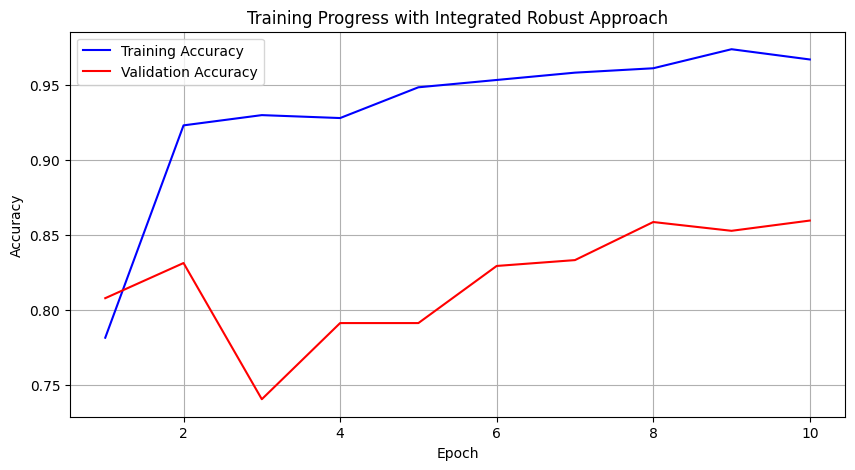

In [21]:
# Run the integrated approach with all patches applied together
robust_model = run_integrated_approach(num_epochs=10)

### Step 8: Systematic Comparison of Robustness Patches

In this section, we'll systematically compare the effectiveness of each robustness patch against each type of corruption:

1. **Baseline** (no patches)
2. **Normalization** patch
3. **Adversarial Training** patch
4. **Label Smoothing** patch
5. **Test-Time Augmentation** patch

Against these corruption types:
1. **Occlusion**
2. **LiDAR Noise**
3. **Registration Error**
4. **Rain**

We'll visualize the results using bar charts and heatmaps to identify the most effective techniques for each type of corruption.

In [18]:
# Define the patches and corruptions we'll compare
patches = [
    "baseline",      # No patches
    "normalization", # Point cloud normalization
    "adversarial",   # Adversarial training (FGSM)
    "label_smooth",  # Label smoothing
    "tta"            # Test-time augmentation
]

# Define the corruption functions with their parameters
corruptions = {
    "clean": None,
    "occlusion": lambda p: add_occlusion(p, num_spheres=3, occlusion_radius=0.3),
    "lidar_noise": lambda p: add_lidar_noise(p, distance_noise=0.01, reflectivity_drop=0.2),
    "registration": lambda p: add_registration_error(p, rotation_error=0.1, translation_error=0.1),
    "rain": lambda p: add_rain(p, rain_density=0.1, rain_length=0.15)
}

# Set number of epochs for training (reduced for this experiment)
training_epochs = 3

def train_model_with_patch(patch_name, num_epochs=training_epochs):
    """Train a model using a specific patch"""
    print(f"Training model with {patch_name} patch...")
    model = SimplePointNet(num_classes=40).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        total, correct = 0, 0
        
        # Different training process for each patch type
        for points, labels in small_train_loader:
            points, labels = points.to(device), labels.to(device)
            
            # Apply normal data augmentation for all
            points = random_rotate_point_cloud(points)
            points = random_jitter_point_cloud(points)
            
            # Apply specific patch during training
            if patch_name == "normalization":
                points = normalize_point_cloud(points)
            elif patch_name == "adversarial":
                # Generate adversarial examples using FGSM
                model.eval()
                with torch.enable_grad():
                    points = fgsm_attack(model, points, labels, epsilon=0.01)
                model.train()
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(points)
            
            # Label smoothing patch
            if patch_name == "label_smooth":
                loss = smooth_cross_entropy(outputs, labels, smoothing=0.1)
            else:
                loss = F.cross_entropy(outputs, labels)
                
            loss.backward()
            optimizer.step()
            
            # Compute accuracy
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += points.size(0)
            
        train_acc = correct / total
        print(f"  Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}")
    
    return model

def evaluate_model_on_corruption(model, patch_name, corruption_name, corruption_fn=None):
    """Evaluate a model on a specific corruption type with the appropriate patch applied"""
    model.eval()
    total, correct = 0, 0
    
    for points, labels in small_test_loader:
        points, labels = points.to(device), labels.to(device)
        
        # Apply corruption if specified
        if corruption_fn is not None:
            points = corruption_fn(points)
        
        # Apply normalization patch during evaluation if specified
        if patch_name == "normalization":
            points = normalize_point_cloud(points)
        
        # Apply TTA patch during evaluation if specified
        if patch_name == "tta":
            outputs = tta_predict(model, points, n_aug=3)
        else:
            with torch.no_grad():
                outputs = model(points)
        
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += points.size(0)
    
    accuracy = correct / total
    return accuracy

In [19]:
# Run experiments for each patch against each corruption type
import pandas as pd
from time import time

# Track results in a DataFrame
results = []

# Train a model for each patch
patch_models = {}
for patch_name in patches:
    print(f"\n=== Training with {patch_name.upper()} patch ===")
    start_time = time()
    model = train_model_with_patch(patch_name)
    training_time = time() - start_time
    patch_models[patch_name] = model
    
    # Evaluate on clean data first
    clean_acc = evaluate_model_on_corruption(model, patch_name, "clean", None)
    results.append({
        "patch": patch_name,
        "corruption": "clean",
        "accuracy": clean_acc,
        "training_time": training_time
    })
    print(f"Clean accuracy with {patch_name} patch: {clean_acc:.4f}")
    
    # Now evaluate on each corruption type
    for corruption_name, corruption_fn in corruptions.items():
        if corruption_name == "clean":
            continue
            
        acc = evaluate_model_on_corruption(model, patch_name, corruption_name, corruption_fn)
        results.append({
            "patch": patch_name,
            "corruption": corruption_name,
            "accuracy": acc,
            "training_time": training_time
        })
        print(f"{corruption_name} corruption accuracy with {patch_name} patch: {acc:.4f}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Save the results to csv for potential later use
results_df.to_csv("patch_comparison_results.csv", index=False)

# Print overall summary
print("\n=== Summary of Results ===")
print(results_df)


=== Training with BASELINE patch ===
Training model with baseline patch...
  Epoch 1/3, Train Acc: 0.7031
  Epoch 1/3, Train Acc: 0.7031
  Epoch 2/3, Train Acc: 0.7910
  Epoch 2/3, Train Acc: 0.7910
  Epoch 3/3, Train Acc: 0.8008
  Epoch 3/3, Train Acc: 0.8008
Clean accuracy with baseline patch: 0.6875
Clean accuracy with baseline patch: 0.6875
occlusion corruption accuracy with baseline patch: 0.6875
occlusion corruption accuracy with baseline patch: 0.6875
lidar_noise corruption accuracy with baseline patch: 0.6875
lidar_noise corruption accuracy with baseline patch: 0.6875
registration corruption accuracy with baseline patch: 0.6875
registration corruption accuracy with baseline patch: 0.6875
rain corruption accuracy with baseline patch: 0.7070

=== Training with NORMALIZATION patch ===
Training model with normalization patch...
rain corruption accuracy with baseline patch: 0.7070

=== Training with NORMALIZATION patch ===
Training model with normalization patch...
  Epoch 1/3, Tra


=== Generating Visualizations ===


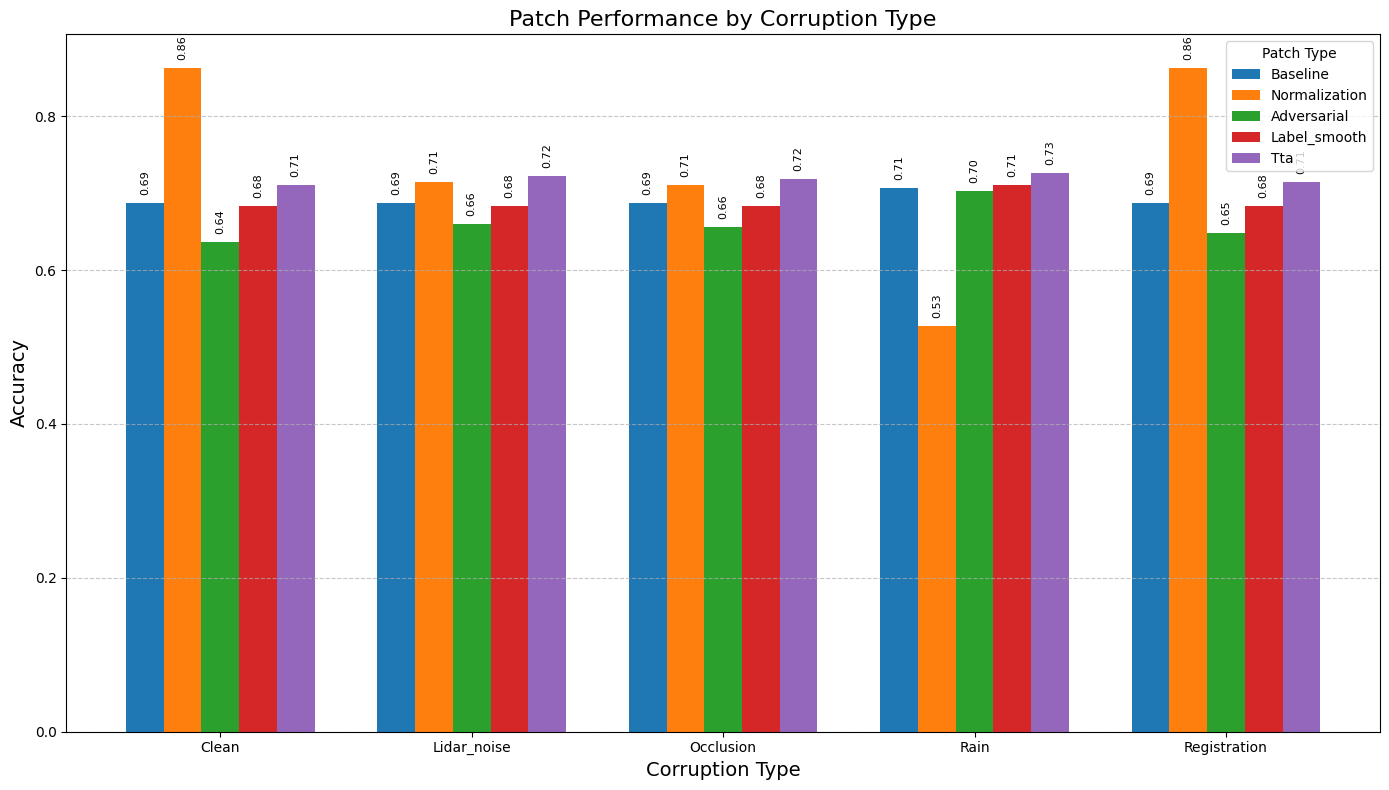

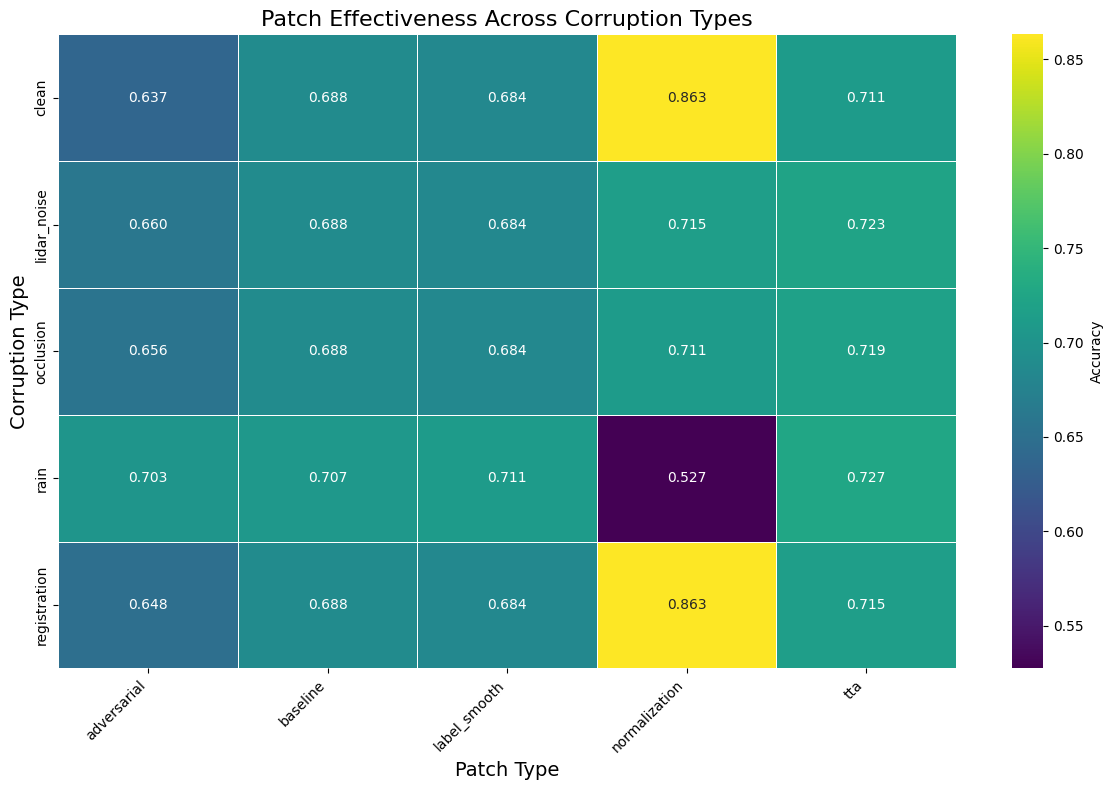

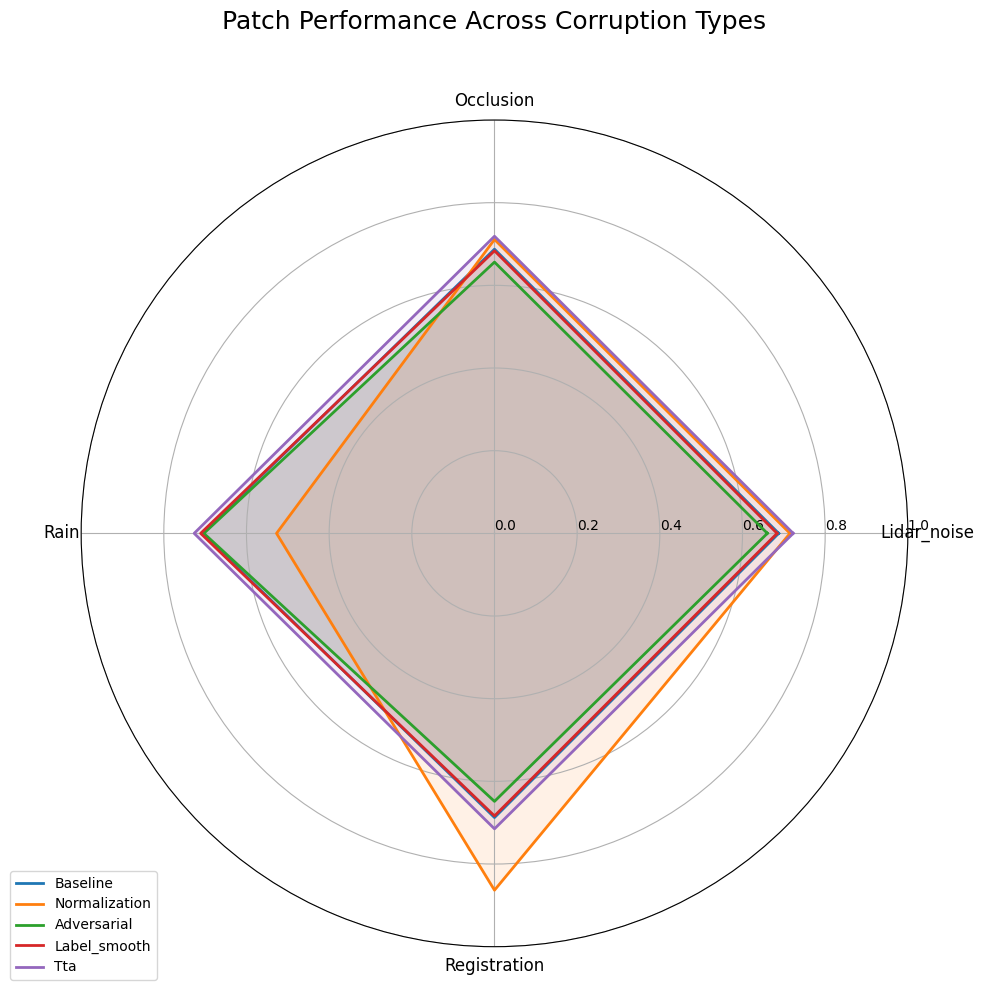

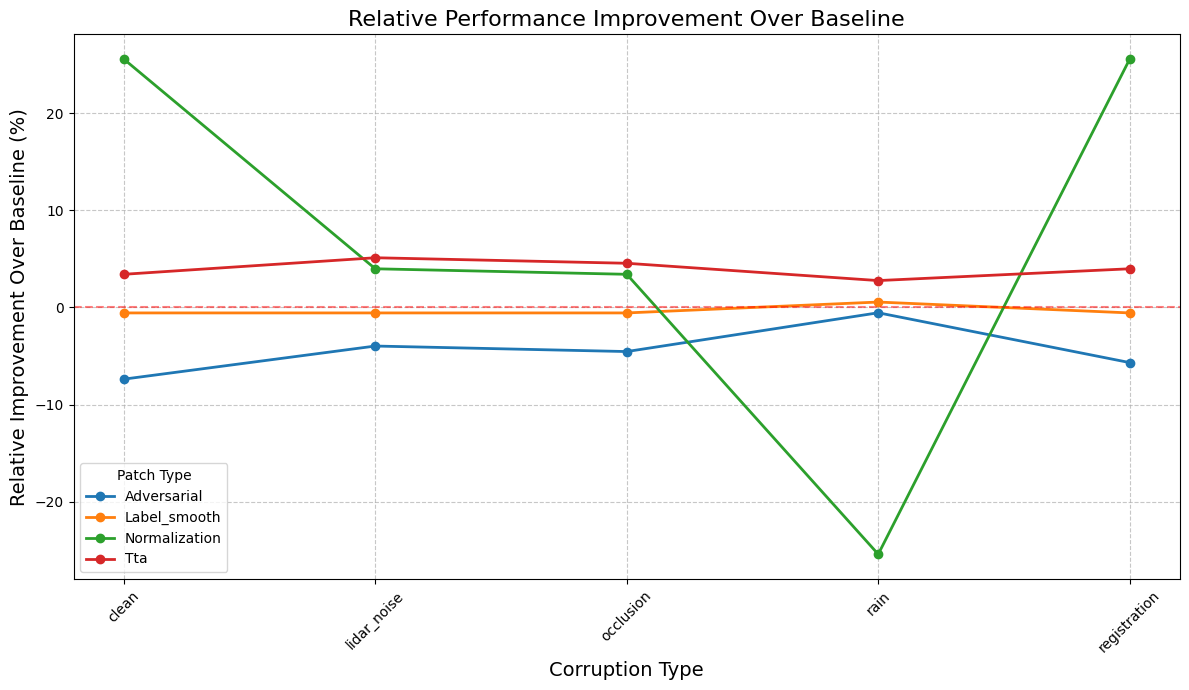

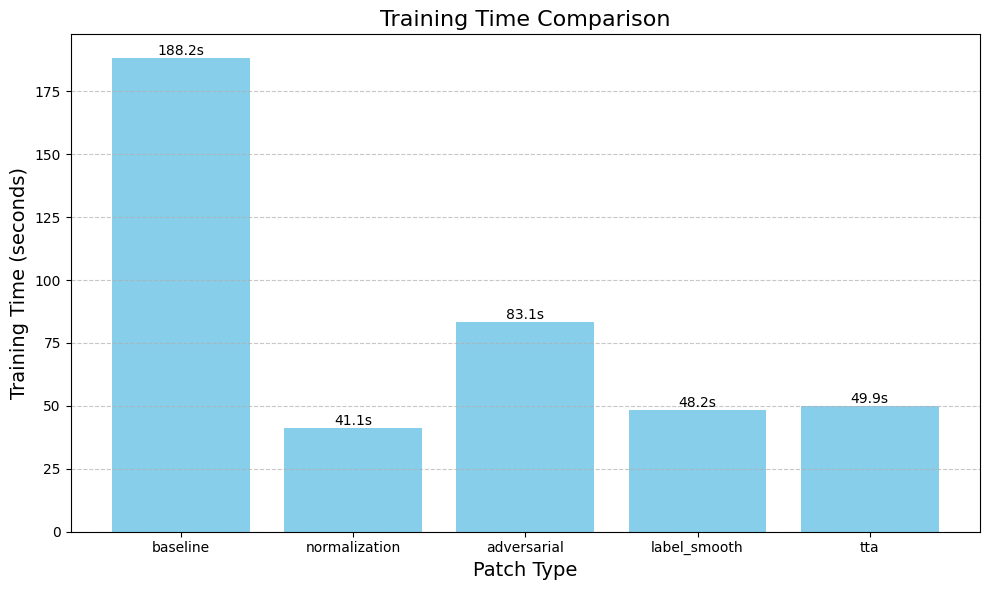

In [20]:
# Create visualizations to compare patch performance
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar chart comparing each patch across corruptions
def plot_patch_performance_by_corruption():
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Pivot the data for easier plotting
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Get unique corruptions and patches
    corruptions_list = pivot_df.index.tolist()
    
    # Set up positions for the bars
    bar_width = 0.15
    x = np.arange(len(corruptions_list))
    
    # Plot bars for each patch
    for i, patch in enumerate(patches):
        offset = (i - len(patches)/2 + 0.5) * bar_width
        ax.bar(x + offset, pivot_df[patch], bar_width, label=patch.capitalize())
    
    # Customize the plot
    ax.set_xlabel('Corruption Type', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('Patch Performance by Corruption Type', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels([c.capitalize() for c in corruptions_list])
    ax.legend(title='Patch Type')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for i, patch in enumerate(patches):
        for j, corruption in enumerate(corruptions_list):
            offset = (i - len(patches)/2 + 0.5) * bar_width
            value = pivot_df.at[corruption, patch]
            ax.text(j + offset, value + 0.01, f'{value:.2f}', 
                    ha='center', va='bottom', rotation=90, fontsize=8)
    
    plt.tight_layout()
    plt.show()

# 2. Create a heatmap for visual comparison
def plot_patch_corruption_heatmap():
    plt.figure(figsize=(12, 8))
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Create the heatmap
    ax = sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', linewidths=.5, cbar_kws={'label': 'Accuracy'})
    
    # Customize the heatmap
    ax.set_title('Patch Effectiveness Across Corruption Types', fontsize=16)
    ax.set_xlabel('Patch Type', fontsize=14)
    ax.set_ylabel('Corruption Type', fontsize=14)
    
    # Make the y labels and x labels capitalize first letter
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. Radar chart for multi-dimensional comparison
def plot_radar_chart():
    # Pivot and prepare data
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Get corruption types excluding 'clean'
    corruption_types = [c for c in pivot_df.index if c != 'clean']
    
    if len(corruption_types) == 0:
        print("No corruption data available for radar chart")
        return
        
    # Number of variables
    N = len(corruption_types)
    
    # What will be the angle of each axis
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], [c.capitalize() for c in corruption_types], size=12)
    
    # Draw the y labels
    ax.set_rlabel_position(0)  # Fixed this line
    y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    plt.yticks(y_ticks, [f"{y:.1f}" for y in y_ticks], size=10)
    plt.ylim(0, 1)
    
    # Plot each patch
    for patch in patches:
        values = pivot_df.loc[corruption_types, patch].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=patch.capitalize())
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Patch Performance Across Corruption Types', size=18, y=1.1)
    plt.tight_layout()
    plt.show()
    
# 4. Line chart showing relative improvement over baseline
def plot_relative_improvement():
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Calculate relative improvement over baseline
    relative_df = pivot_df.copy()
    for col in relative_df.columns:
        if col != 'baseline':
            relative_df[col] = (relative_df[col] - relative_df['baseline']) / relative_df['baseline'] * 100
    
    # Drop baseline column as it will be all zeros
    relative_df = relative_df.drop(columns=['baseline'])
    
    # Plot
    plt.figure(figsize=(12, 7))
    for patch in relative_df.columns:
        plt.plot(relative_df.index, relative_df[patch], marker='o', linewidth=2, label=patch.capitalize())
    
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Corruption Type', fontsize=14)
    plt.ylabel('Relative Improvement Over Baseline (%)', fontsize=14)
    plt.title('Relative Performance Improvement Over Baseline', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Patch Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 5. Bar chart showing training time comparison
def plot_training_time_comparison():
    # Extract unique patch and their training time
    time_df = results_df.drop_duplicates(subset=['patch'])[['patch', 'training_time']]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(time_df['patch'], time_df['training_time'], color='skyblue')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}s', ha='center', va='bottom')
    
    plt.xlabel('Patch Type', fontsize=14)
    plt.ylabel('Training Time (seconds)', fontsize=14)
    plt.title('Training Time Comparison', fontsize=16)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call all visualization functions
print("\n=== Generating Visualizations ===")
plot_patch_performance_by_corruption()
plot_patch_corruption_heatmap()
plot_radar_chart()
plot_relative_improvement()
plot_training_time_comparison()

In [21]:
# Fix for the radar chart function
def plot_radar_chart():
    # Pivot and prepare data
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Get corruption types excluding 'clean'
    corruption_types = [c for c in pivot_df.index if c != 'clean']
    
    if len(corruption_types) == 0:
        print("No corruption data available for radar chart")
        return
        
    # Number of variables
    N = len(corruption_types)
    
    # What will be the angle of each axis
    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], [c.capitalize() for c in corruption_types], size=12)
    
    # Draw the y labels
    ax.set_rlabel_position(0)  # Fixed this line
    y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    plt.yticks(y_ticks, [f"{y:.1f}" for y in y_ticks], size=10)
    plt.ylim(0, 1)
    
    # Plot each patch
    for patch in patches:
        values = pivot_df.loc[corruption_types, patch].tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=patch.capitalize())
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Patch Performance Across Corruption Types', size=18, y=1.1)
    plt.tight_layout()
    plt.show()

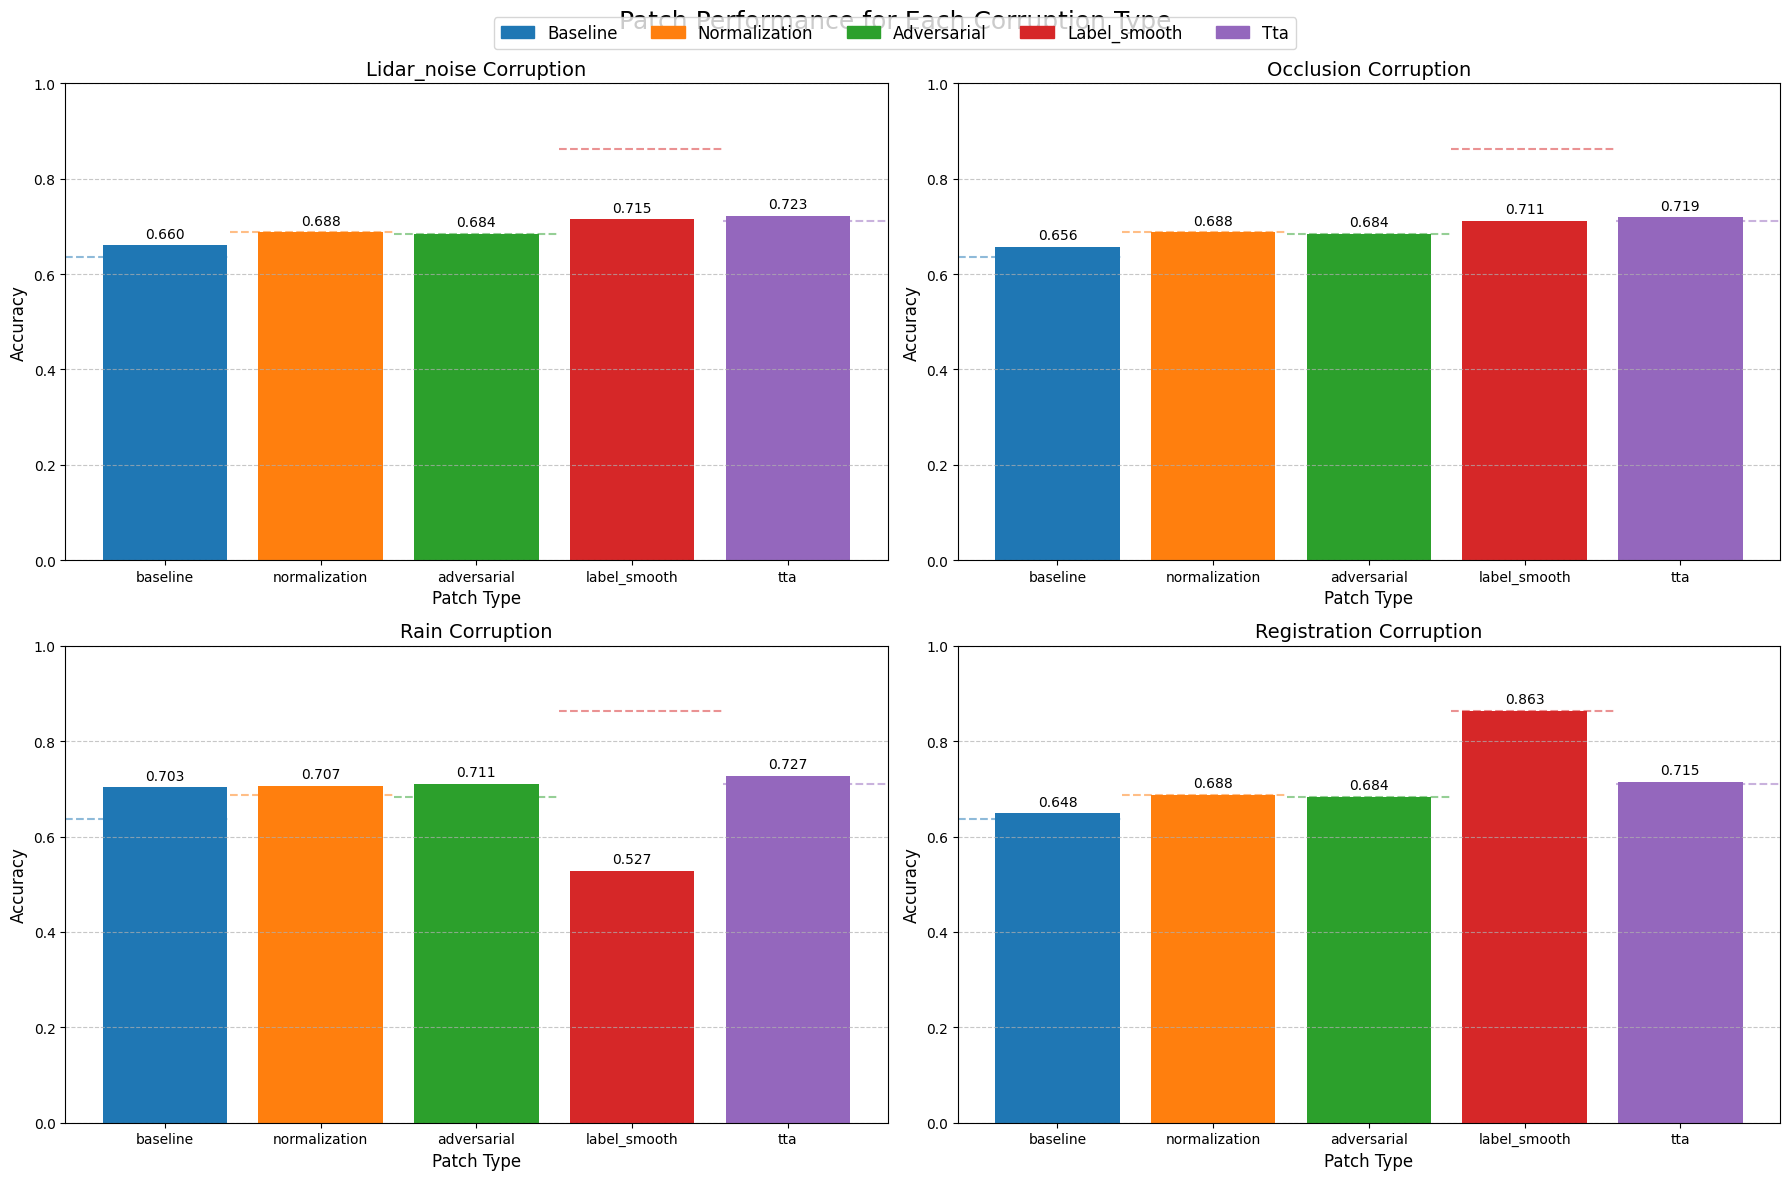

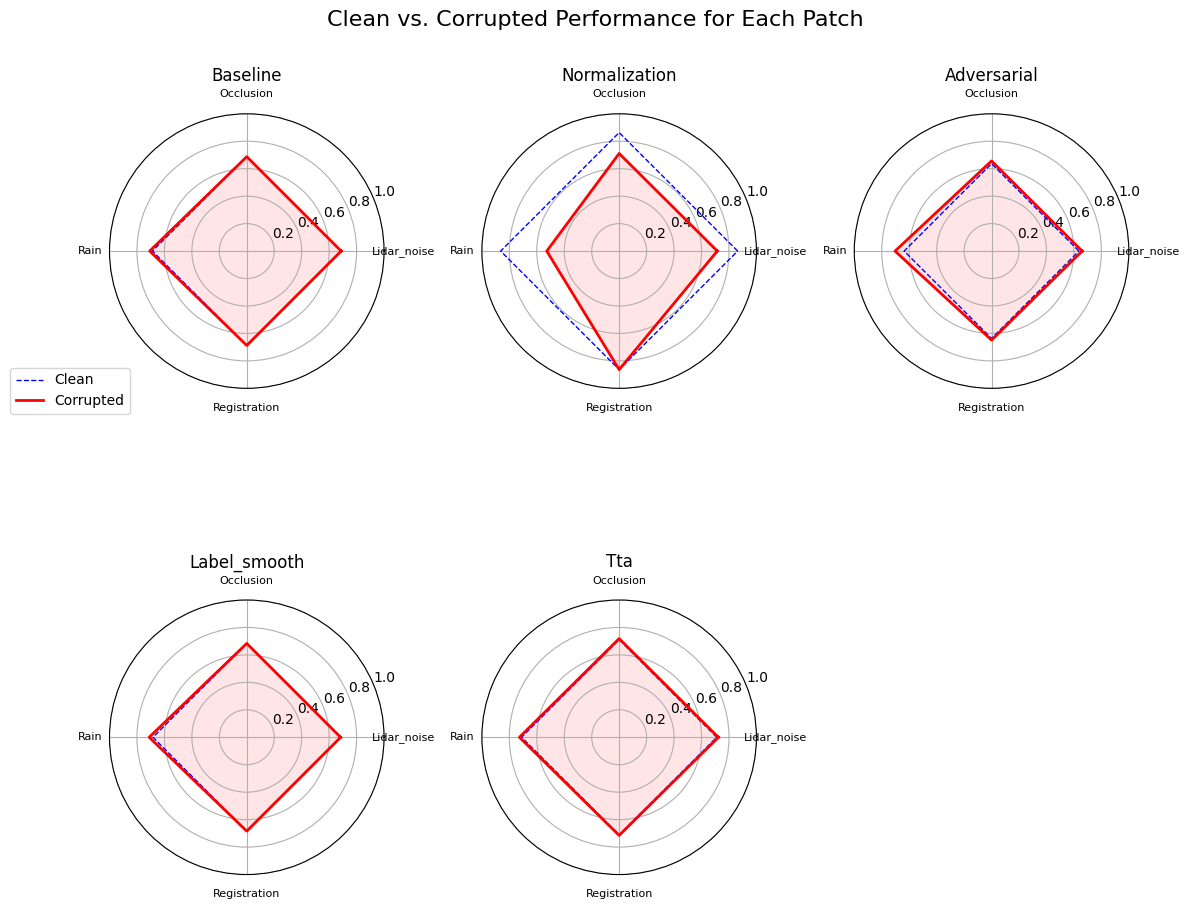

In [22]:
# Create individual charts for each corruption type
def plot_corruption_specific_charts():
    # Pivot the data for easier plotting
    pivot_df = results_df.pivot_table(index='corruption', columns='patch', values='accuracy')
    
    # Get list of corruptions excluding clean
    corruption_types = [c for c in pivot_df.index if c != 'clean']
    
    # Create a subplot for each corruption type
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    # Colors for each patch
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, corruption in enumerate(corruption_types):
        ax = axes[i]
        
        # Extract data for this corruption
        accuracies = pivot_df.loc[corruption].values
        
        # Create bar chart
        bars = ax.bar(patches, accuracies, color=colors)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Add clean accuracy as a horizontal line for reference
        clean_accuracies = pivot_df.loc['clean'].values
        for j, patch in enumerate(patches):
            ax.axhline(y=clean_accuracies[j], color=colors[j], linestyle='--', alpha=0.5,
                       xmin=j/len(patches), xmax=(j+1)/len(patches))
        
        # Customize chart
        ax.set_title(f'{corruption.capitalize()} Corruption', fontsize=14)
        ax.set_xlabel('Patch Type', fontsize=12)
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
    # Add a legend to the figure
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(patches))]
    fig.legend(handles, [p.capitalize() for p in patches], loc='upper center', ncol=5,
             bbox_to_anchor=(0.5, 0.98), fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Patch Performance for Each Corruption Type', fontsize=18)
    plt.show()
    
    # Create a radar chart specifically comparing clean vs. corrupted performance
    fig = plt.figure(figsize=(12, 10))
    
    # For each patch, create a radar chart showing clean vs corrupted performance
    for p_idx, patch in enumerate(patches):
        ax = fig.add_subplot(2, 3, p_idx+1, projection='polar')
        
        # Get clean accuracy
        clean_acc = pivot_df.loc['clean', patch]
        
        # Get accuracies for each corruption type
        corruption_accs = [pivot_df.loc[c, patch] for c in corruption_types]
        
        # Calculate angles for the radar chart
        N = len(corruption_types)
        angles = [n / N * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Add clean accuracy as a circular line
        clean_circle = [clean_acc] * (N + 1)
        
        # Add corruption accuracies
        corruption_accs += [corruption_accs[0]]  # Close the loop
        
        # Plot
        ax.plot(angles, clean_circle, 'b--', linewidth=1, label='Clean')
        ax.plot(angles, corruption_accs, 'r-', linewidth=2, label='Corrupted')
        ax.fill(angles, corruption_accs, 'r', alpha=0.1)
        
        # Customize
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([c.capitalize() for c in corruption_types], size=8)
        ax.set_ylim(0, 1)
        ax.set_title(patch.capitalize(), fontsize=12)
        
        if p_idx == 0:  # Add legend only to first subplot
            ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.tight_layout()
    plt.suptitle('Clean vs. Corrupted Performance for Each Patch', fontsize=16, y=0.98)
    plt.show()

# Call the function
plot_corruption_specific_charts()